In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import xml

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [3]:
imgs = list(sorted(os.listdir("kaggle/input/face-mask-detection/images/")))
labels = list(sorted(os.listdir("kaggle/input/face-mask-detection/annotations/")))
# input\face-mask-detection\images

In [4]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("kaggle/input/face-mask-detection/images/")))
        # self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("kaggle/input/face-mask-detection/images/", file_image)
        label_path = os.path.join("kaggle/input/face-mask-detection/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)

train_size=int(len(dataset)*0.7)
test_size=len(dataset)-train_size
print('Length of dataset is', len(dataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

trainset, testset = torch.utils.data.random_split(dataset,[train_size,test_size])
train_dataloader = torch.utils.data.DataLoader(dataset=trainset,batch_size=4,shuffle=True,collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(dataset=testset,batch_size=4,shuffle=True,collate_fn=collate_fn)
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=4, collate_fn=collate_fn)

Length of dataset is 853 
Length of training set is : 597 
Length of test set is : 256


In [6]:
torch.cuda.is_available()

True

MODEL

In [7]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
model = get_model_instance_segmentation(3)

C:\Users\Eileen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Eileen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
print(model.transform)

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)


In [ ]:
print(model)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
for imgs, annotations in train_dataloader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

cuda
[{'boxes': tensor([[ 63., 124.,  96., 160.],
        [152., 129., 181., 164.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([700], device='cuda:0')}, {'boxes': tensor([[ 14., 140.,  32., 161.],
        [113., 113., 131., 137.],
        [165., 116., 183., 137.],
        [206.,  89., 228., 114.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'image_id': tensor([754], device='cuda:0')}, {'boxes': tensor([[ 52., 198., 172., 337.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([644], device='cuda:0')}, {'boxes': tensor([[ 32., 165.,  67., 202.],
        [171., 193., 204., 229.],
        [279., 172., 313., 213.],
        [102., 199., 118., 220.],
        [240., 189., 258., 210.]], device='cuda:0'), 'labels': tensor([1, 1, 2, 0, 0], device='cuda:0'), 'image_id': tensor([673], device='cuda:0')}]


TRAIN MODEL

In [17]:
num_epochs = 10
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_dataloader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in train_dataloader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(43.7828, device='cuda:0', grad_fn=<AddBackward0>)
tensor(44.8148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.4001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.6531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.7687, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.9316, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.7109, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.9408, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.9949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.8721, device='cuda:0', grad_fn=<AddBackward0>)


In [18]:
for imgs, annotations in test_dataloader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[143.2424,  83.6223, 195.7516, 134.3078]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.1076], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[7.7505e+01, 2.3491e+02, 1.0113e+02, 2.6088e+02],
          [2.5001e+01, 2.3472e+02, 4.9142e+01, 2.6117e+02],
          [3.0836e+02, 2.1929e+02, 3.3069e+02, 2.4047e+02],
          [1.2073e+02, 2.4476e+02, 1.4505e+02, 2.6968e+02],
          [1.4317e+02, 5.5128e+01, 1.5745e+02, 7.2520e+01],
          [3.8670e+01, 1.5976e+02, 6.0305e+01, 1.8305e+02],
          [2.5544e+02, 1.8653e+02, 2.7771e+02, 2.1003e+02],
          [2.5087e+02, 1.2290e+01, 2.6344e+02, 2.6356e+01],
          [2.0793e+02, 1.9243e+02, 2.2981e+02, 2.1429e+02],
          [2.0771e+02, 6.4994e+01, 2.2544e+02, 8.5208e+01],
          [7.6583e+01, 3.4450e+01, 9.1408e+01, 5.0715e+01],
          [2.8076e+02, 8.2966e+01, 2.9851e+02, 1.0197e+02],
          [9.9670e+01, 1.2054e+02, 1.151

Function to Plot Image

In [19]:
print(preds[2]["boxes"].cpu().data)

tensor([[ 54.6178, 100.8441, 106.2792, 158.6843],
        [284.3506,  94.9272, 360.2281, 178.9340],
        [ 26.3394,  40.4417,  38.8906,  57.8713],
        [281.0667,  91.5653, 362.7880, 179.8898],
        [ 51.4639,  96.7057, 107.5500, 160.1212]])


Prediction


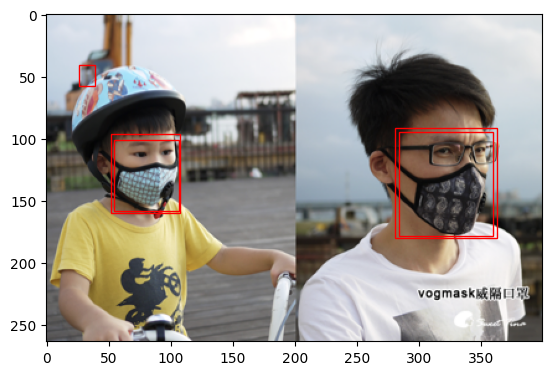

Target


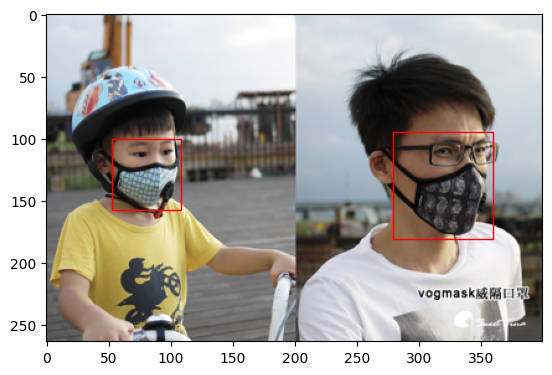

In [22]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    annots = annotation["boxes"].cpu().data
    
    for box in annots:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

torch.save(model.state_dict(),'model_fasterrcnn.pt')
model2 = get_model_instance_segmentation(3)

Save Model

In [23]:
model2.load_state_dict(torch.load('model_fasterrcnn.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Load Model

Predict with loaded model


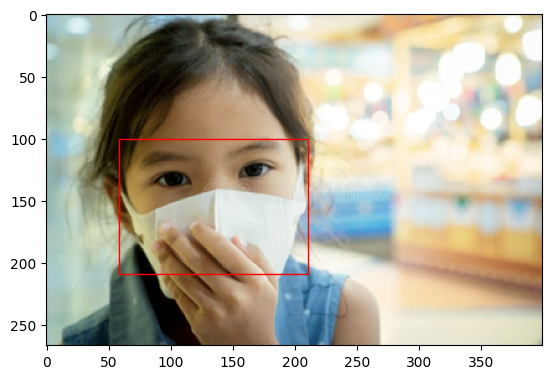

In [24]:
pred2 = model2(imgs)

print("Predict with loaded model")
plot_image(imgs[3], pred2[3])